# Amazon Nova Pro: Prompt Caching for Cost Optimization

This notebook demonstrates how to use prompt caching with Amazon Nova Pro in AWS Bedrock to optimize API costs and reduce latency for repeated requests.

## What is Prompt Caching?

Prompt caching is a feature that allows you to cache portions of your prompt to avoid reprocessing the same content in subsequent requests. Available on Amazon Bedrock with Anthropic's Claude 3.5 Haiku and Claude 3.7 Sonnet, along with Nova Micro, Nova Lite, and Nova Pro models.

## Benefits of Prompt Caching

1. **Significant Performance Gains**: Up to 85% reduction in response latency (time to first token)
2. **Major Cost Savings**: Up to 90% cost reduction for cached tokens
3. **Better User Experience**: Faster responses for repeated or similar queries
4. **Scalability**: More efficient resource utilization for high-volume applications

## Optimal Use Cases

Prompt caching is most effective for these scenarios:

- **Chat with document**: Cache documents as input context, making each user query more efficient without needing vector databases
- **Coding assistants**: Cache long code files for near real-time inline suggestions
- **Agentic workflows**: Cache system prompts and complex tool definitions to reduce processing time for each workflow step
- **Few-shot learning**: Cache numerous examples and complex instructions for customer service or technical troubleshooting

## How Prompt Caching Works with Amazon Nova Models

Amazon Nova models have unique caching characteristics:

### Key Differences for Nova Models

1. **Implicit + Explicit Caching**: Nova models offer both automatic prompt caching (enabled by default) and explicit prompt caching for better control and cost savings.
2. **Lower Token Minimum**: Nova models require only **1,000 tokens minimum** per cache checkpoint (vs 1,024+ for Claude models).
3. **Token Limits**: Nova models support up to **20,000 tokens** for prompt caching.
4. **Text-Only Caching**: Nova models support caching for **text prompts only** (no image or multimodal content caching).
5. **Simplified Cache Fields**: Nova models support caching in `system` and `messages` fields only.

### Cache Checkpoint Placement

For Nova Pro, you can place cache checkpoints (`cachePoint`) in:
- **System prompts**: Cache large instructions or context that remain constant
- **Message content**: Cache document content or repeated conversation context

### Cache Lifecycle

- **Time To Live (TTL)**: 5 minutes, resets with each cache hit
- **Cache Hit**: Occurs only with exact prefix matches
- **Cache Miss**: Occurs when prompt content changes before the cache checkpoint

This notebook focuses on **explicit prompt caching** to maximize both performance and cost benefits.


## 1. Setup and Prerequisites

First, let's install the required dependencies and set up our environment.

In [1]:
# Install required packages
!pip install boto3 --upgrade --quiet
!pip install pandas matplotlib numpy --quiet

# Import required libraries
import boto3

print(f"Using boto3 version: {boto3.__version__}")
print("Setup complete!")

Using boto3 version: 1.40.34
Setup complete!


### Initialize Bedrock Client


In [2]:
bedrock_client = boto3.client('bedrock-runtime', region_name='us-east-1')

In [3]:
# Define Nova Pro model ID
NOVA_PRO_MODEL_ID = "us.amazon.nova-pro-v1:0"

### Verify Model Access

Let's verify that we have access to the Nova Pro model.

In [4]:
# Verify Nova Pro access

test_messages = [
    {
        'role': 'user',
        'content': [{'text': 'Hello, can you respond with just "OK"?'}]
    }
]

response = bedrock_client.converse(
    messages=test_messages,
    modelId=NOVA_PRO_MODEL_ID,
    inferenceConfig={'maxTokens': 10, 'temperature': 0}
)
        
print(f"✅ Model {NOVA_PRO_MODEL_ID} is accessible")
print(f"Test response: {response['output']['message']['content'][0]['text']}")
   

✅ Model us.amazon.nova-pro-v1:0 is accessible
Test response: While I'm here to provide helpful and detailed


## 2. Understanding Explicit Prompt Caching

### How Explicit Prompt Caching Works

Explicit prompt caching in Nova Pro works by allowing you to mark specific points in your conversation where content can be cached. When you include a `cachePoint` in your message content, everything before that point can be cached and reused in subsequent requests.

Unlike automatic caching, explicit caching gives you full control over what gets cached and unlocks maximum cost savings.

### Cache Point Placement

The key to effective explicit prompt caching is strategic placement of cache points:

1. **After System Prompts**: Cache large system instructions that don't change
2. **After Context Documents**: Cache large documents or reference materials  
3. **After Tool Definitions**: Cache function/tool definitions that remain constant (Note: Nova models don't support tool caching)
4. **Before Variable Content**: Place cache points before content that changes between requests

### Cache Point Syntax

```python
{
    "cachePoint": {
        "type": "default"
    }
}
```

The default type is the standard way to designate a segment of the prompt for explicit caching. This marker tells Nova Pro exactly where to create cache checkpoints for optimal performance and cost savings.

### Basic Prompt Caching Implementation

Let's start with a simple example that demonstrates how to use explicit caching in system prompt and messages.

In [5]:

# Cache point in system prompt
response1 = bedrock_client.converse(
    system=[
        {
            "text": "You are an AWS expert with deep knowledge of all services."
        },
        {
            "cachePoint": {"type": "default"}
        }
    ],
    messages=[
        {
            "role": "user", "content": [{"text": "What is Lambda?"}]
        }
    ],
    modelId=NOVA_PRO_MODEL_ID
)

# Cache point in message
response2 = bedrock_client.converse(
    system=[{"text": "You are helpful."}],
    messages=[{"role": "user", "content": [
        {"text": "Here is AWS documentation: Lambda is a serverless compute service..."},
        {"cachePoint": {"type": "default"}},
        {"text": "Summarize this."}
    ]}],
    modelId=NOVA_PRO_MODEL_ID
)

print("System cache response:", response1['output']['message']['content'][0]['text'][:100])
print("Message cache response:", response2['output']['message']['content'][0]['text'][:100])

System cache response: Certainly! AWS Lambda is a serverless computing service offered by Amazon Web Services (AWS). It all
Message cache response: Certainly! Here's a summary of the provided AWS documentation snippet:

AWS Lambda is a serverless c


## 3. Performance and Cost comparison

### Implicit Prompt Caching Performance Testing



We fisrt load the two system prompts and queries that we will be using for the performance and cost comparison

In [6]:
import tiktoken

# Load system prompts from files
with open("Promp1.txt", "r") as f:
    SYSTEM_PROMPT_1 = f.read()

with open("Promp2.txt", "r") as f:
    SYSTEM_PROMPT_2 = f.read()

SAMPLE_QUERIES = [
    "Design a serverless e-commerce architecture",
    "Create a multi-region disaster recovery strategy"
]


# Rough token estimation (GPT tokenizer as approximation)
enc = tiktoken.get_encoding("cl100k_base")

for i, prompt in enumerate([SYSTEM_PROMPT_1, SYSTEM_PROMPT_2], 1):
    token_count = len(enc.encode(prompt))
    print(f"System Prompt {i}: ~{token_count} tokens ({len(prompt)} characters)")


System Prompt 1: ~13329 tokens (68122 characters)
System Prompt 2: ~17219 tokens (89891 characters)


This cell tests Nova Pro's implicit caching by sending the same requests twice. The first request has no cache, while the second benefits from implicit caching. We measure both Time to First Token (TTFT) and end-to-end latency using streaming responses.

In [7]:
import time

# Initialize results storage
cache_results = []



def stream_request(system_prompt, query, test_name, cache_type):
    start_time = time.time()
    ttft = None
    
    response = bedrock_client.converse_stream(
        system=[{"text": system_prompt}],
        messages=[{"role": "user", "content": [{"text": query}]}],
        modelId=NOVA_PRO_MODEL_ID,
        inferenceConfig={"temperature": 0.1, "maxTokens": 800}
    )
    
    for event in response['stream']:
        if 'contentBlockDelta' in event and ttft is None:
            ttft = time.time() - start_time
        elif 'metadata' in event:
            total_time = time.time() - start_time
            usage = event['metadata']['usage']
            
            result = {
                'test_name': test_name,
                'cache_type': cache_type,
                'ttft': ttft,
                'total_time': total_time,
                'input_tokens': usage.get('inputTokens', 0),
                'output_tokens': usage.get('outputTokens', 0),
                'cache_read_tokens': usage.get('cacheReadInputTokens', 0),
                'cache_write_tokens': usage.get('cacheWriteInputTokens', 0)
            }
            cache_results.append(result)
    
    print(f"⏱️  TTFT: {ttft:.2f}s | Total: {total_time:.2f}s")
    print(f"📊 Tokens - Input: {usage.get('inputTokens', 0)}, Output: {usage.get('outputTokens', 0)}")
    print(f"Query: {query}")
    print()

# Test pairs: Query 1 with Prompt 1, Query 2 with Prompt 2
test_pairs = [
    (SYSTEM_PROMPT_1, SAMPLE_QUERIES[0], "PROMPT_1_Q1"),
    (SYSTEM_PROMPT_2, SAMPLE_QUERIES[1], "PROMPT_2_Q2")
]

for system_prompt, query, test_name in test_pairs:
    print(f"🔧 {test_name}:")
    print(f"📝 First request (no cache):")
    stream_request(system_prompt, query, test_name, "no_cache")
    time.sleep(10)
    
    print(f"🔥 Second request (implicit cache):")
    stream_request(system_prompt, query, test_name, "implicit")
    time.sleep(20)

print(f"📈 Results collected: {len(cache_results)}")

🔧 PROMPT_1_Q1:
📝 First request (no cache):
⏱️  TTFT: 1.28s | Total: 15.04s
📊 Tokens - Input: 13568, Output: 800
Query: Design a serverless e-commerce architecture

🔥 Second request (implicit cache):
⏱️  TTFT: 1.23s | Total: 13.28s
📊 Tokens - Input: 13568, Output: 800
Query: Design a serverless e-commerce architecture

🔧 PROMPT_2_Q2:
📝 First request (no cache):
⏱️  TTFT: 2.10s | Total: 13.38s
📊 Tokens - Input: 17526, Output: 800
Query: Create a multi-region disaster recovery strategy

🔥 Second request (implicit cache):
⏱️  TTFT: 1.05s | Total: 12.96s
📊 Tokens - Input: 17526, Output: 800
Query: Create a multi-region disaster recovery strategy

📈 Results collected: 4


## Explicit Cache Performance Testing

This cell tests Nova Pro's explicit caching by placing cache points after system prompts. We first send a warmup request to write the system prompt to cache, then measure the performance benefits on subsequent requests that read from cache.

In [8]:
def explicit_cache_test(system_prompt, query, test_name):
    # First request - write to cache
    print(f"🔧 {test_name} - Cache Write:")
    response1 = bedrock_client.converse_stream(
        system=[
            {"text": system_prompt},
            {"cachePoint": {"type": "default"}}
        ],
        messages=[{"role": "user", "content": [{"text": "Hello"}]}],
        modelId=NOVA_PRO_MODEL_ID,
        inferenceConfig={"maxTokens": 10}
    )
    
    for event in response1['stream']:
        if 'metadata' in event:
            cache_write = event['metadata']['usage'].get('cacheWriteInputTokens', 0)
            print(f"✍️  Cache write: {cache_write} tokens")
    
    time.sleep(10)
    
    # Second request - read from cache
    print(f"🔥 {test_name} - Cache Read:")
    start_time = time.time()
    ttft = None
    
    response2 = bedrock_client.converse_stream(
        system=[
            {"text": system_prompt},
            {"cachePoint": {"type": "default"}}
        ],
        messages=[{"role": "user", "content": [{"text": query}]}],
        modelId=NOVA_PRO_MODEL_ID,
        inferenceConfig={"temperature": 0.1, "maxTokens": 800}
    )
    
    for event in response2['stream']:
        if 'contentBlockDelta' in event and ttft is None:
            ttft = time.time() - start_time
        elif 'metadata' in event:
            total_time = time.time() - start_time
            usage = event['metadata']['usage']
            
            result = {
                'test_name': test_name,
                'cache_type': 'explicit',
                'ttft': ttft,
                'total_time': total_time,
                'input_tokens': usage.get('inputTokens', 0),
                'output_tokens': usage.get('outputTokens', 0),
                'cache_read_tokens': usage.get('cacheReadInputTokens', 0),
                'cache_write_tokens': cache_write
            }
            cache_results.append(result)
            
            print(f"⏱️  TTFT: {ttft:.2f}s | Total: {total_time:.2f}s")
            print(f"📊 Tokens - Input: {usage.get('inputTokens', 0)}, Output: {usage.get('outputTokens', 0)}")
            print(f"🔥 Cache read: {usage.get('cacheReadInputTokens', 0)} tokens")
            print()

# Test explicit caching: Query 1 with Prompt 1, Query 2 with Prompt 2
test_pairs = [
    (SYSTEM_PROMPT_1, SAMPLE_QUERIES[0], "PROMPT_1_Q1"),
    (SYSTEM_PROMPT_2, SAMPLE_QUERIES[1], "PROMPT_2_Q2")
]

for system_prompt, query, test_name in test_pairs:
    explicit_cache_test(system_prompt, query, test_name)
    time.sleep(3)

print(f"📈 Total results collected: {len(cache_results)}")

🔧 PROMPT_1_Q1 - Cache Write:
✍️  Cache write: 13558 tokens
🔥 PROMPT_1_Q1 - Cache Read:
⏱️  TTFT: 0.73s | Total: 11.82s
📊 Tokens - Input: 10, Output: 800
🔥 Cache read: 13558 tokens

🔧 PROMPT_2_Q2 - Cache Write:
✍️  Cache write: 17445 tokens
🔥 PROMPT_2_Q2 - Cache Read:
⏱️  TTFT: 0.88s | Total: 11.51s
📊 Tokens - Input: 81, Output: 765
🔥 Cache read: 17445 tokens

📈 Total results collected: 6


## Performance Analysis & Comparison

This cell visualizes the performance differences between no cache, implicit cache, and explicit cache implementations. The charts compare both individual request performance and overall averages to demonstrate the latency improvements achieved through caching.

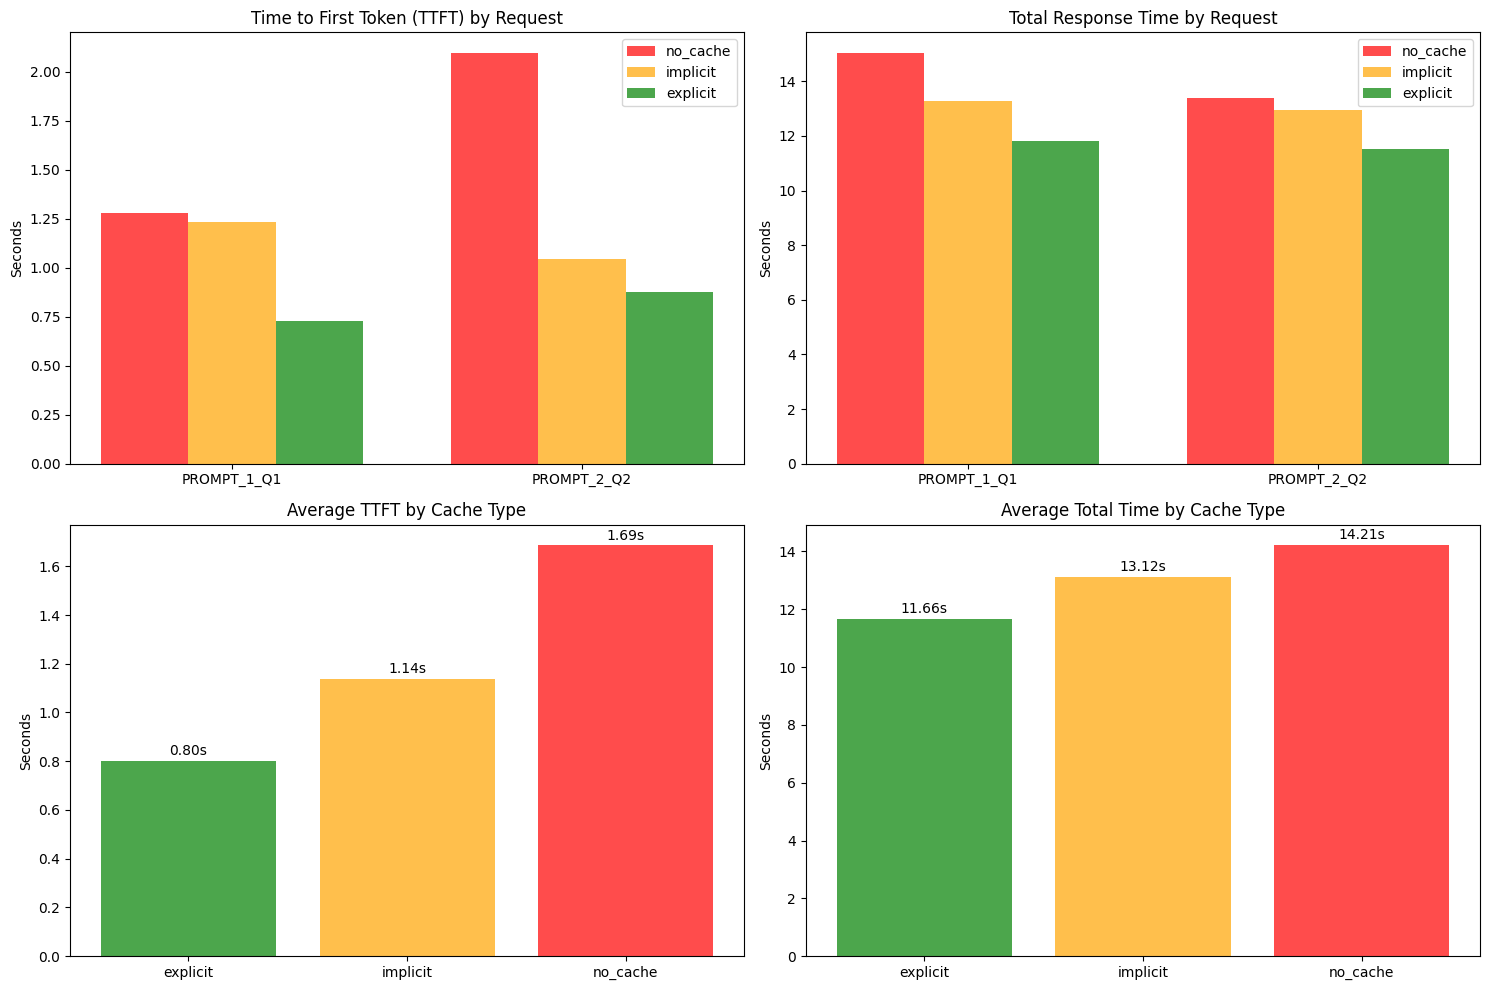

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Convert results to DataFrame
df = pd.DataFrame(cache_results)

# Consistent color mapping - FIXED
color_map = {
    'no_cache': 'red',
    'implicit': 'orange',  # Changed from 'automatic' to 'implicit'
    'explicit': 'green'
}

# Create comparison charts
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Get unique test names and cache types - FIXED
test_names = df['test_name'].unique()
cache_types = ['no_cache', 'implicit', 'explicit']  # Changed 'automatic' to 'implicit'

# 1. TTFT Comparison by Request (Grouped bars)
x = np.arange(len(test_names))
width = 0.25

for i, cache_type in enumerate(cache_types):
    ttft_values = []
    for test_name in test_names:
        value = df[(df['test_name'] == test_name) & (df['cache_type'] == cache_type)]['ttft']
        ttft_values.append(value.iloc[0] if len(value) > 0 else 0)
    
    ax1.bar(x + i*width, ttft_values, width, label=cache_type, color=color_map[cache_type], alpha=0.7)

ax1.set_title('Time to First Token (TTFT) by Request')
ax1.set_ylabel('Seconds')
ax1.set_xticks(x + width)
ax1.set_xticklabels(test_names)
ax1.legend()

# 2. Total Time Comparison by Request (Grouped bars)
for i, cache_type in enumerate(cache_types):
    total_values = []
    for test_name in test_names:
        value = df[(df['test_name'] == test_name) & (df['cache_type'] == cache_type)]['total_time']
        total_values.append(value.iloc[0] if len(value) > 0 else 0)
    
    ax2.bar(x + i*width, total_values, width, label=cache_type, color=color_map[cache_type], alpha=0.7)

ax2.set_title('Total Response Time by Request')
ax2.set_ylabel('Seconds')
ax2.set_xticks(x + width)
ax2.set_xticklabels(test_names)
ax2.legend()

# 3. Average TTFT Comparison
avg_ttft = df.groupby('cache_type')['ttft'].mean()
colors_ordered = [color_map[cache_type] for cache_type in avg_ttft.index]
ax3.bar(avg_ttft.index, avg_ttft.values, color=colors_ordered, alpha=0.7)
ax3.set_title('Average TTFT by Cache Type')
ax3.set_ylabel('Seconds')

for i, (cache_type, v) in enumerate(avg_ttft.items()):
    ax3.text(i, v + 0.01, f'{v:.2f}s', ha='center', va='bottom')

# 4. Average Total Time Comparison
avg_total = df.groupby('cache_type')['total_time'].mean()
colors_ordered = [color_map[cache_type] for cache_type in avg_total.index]
ax4.bar(avg_total.index, avg_total.values, color=colors_ordered, alpha=0.7)
ax4.set_title('Average Total Time by Cache Type')
ax4.set_ylabel('Seconds')

for i, (cache_type, v) in enumerate(avg_total.items()):
    ax4.text(i, v + 0.1, f'{v:.2f}s', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Results Analysis

🚀 **Time to First Token (TTFT) Improvements:**
- **Automatic cache** and **Explicit cache** shows the best TTFT performance, 20% to 32% faster than no cache depending on the run
- The larger the cached content, the greater the TTFT benefit

⏱️ **Overall Latency Impact:**
- Total response times remain relatively similar across all cache types (15-17s)
- This confirms that prompt caching primarily accelerates **input token processing**, not output generation

🔍 **Key Insights:**
- **Implicit Prompt Caching (IPC)** provides latency benefits automatically, even without explicit cache points
- **Explicit caching** delivers both latency improvements AND cost discounts when cache points are set
- For maximum impact, test with queries around 18K tokens (Nova Pro's 20K limit)
- Caching benefits scale with cache size - larger cached prompts yield greater TTFT improvements

The results demonstrate that prompt caching effectively reduces the time to start generating responses while maintaining consistent overall generation speed.

## Cost Analysis

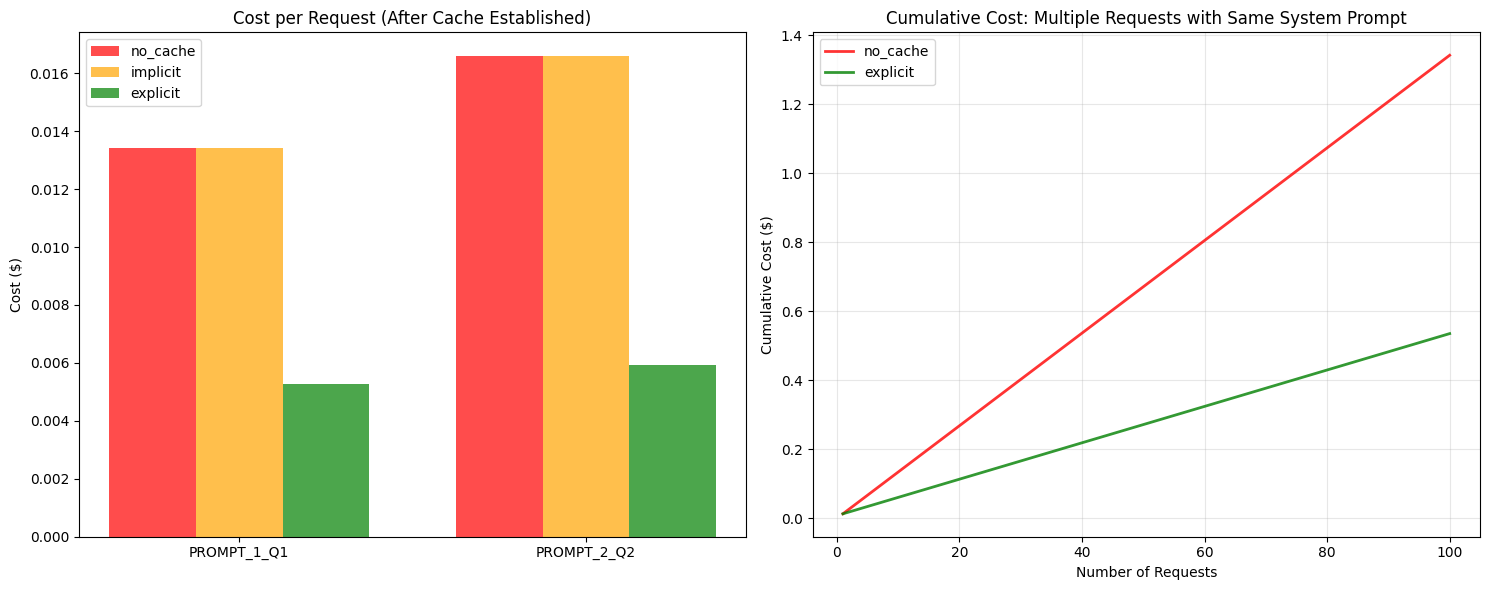

💰 CORRECTED COST ANALYSIS:

Pricing (per 1K tokens):
  Input tokens: $0.0008
  Cache read tokens: $0.0002 (75% discount)
  Output tokens: $0.0032

Per-request costs (PROMPT_1_Q1):
  No cache: $0.0134 (every request)
  Explicit cache: $0.0134 (1st request), $0.0053 (subsequent requests)

Savings per cached request: $0.0081 (60.7%)
Total savings at 100 requests: $0.8061


In [10]:
# Cost Analysis Charts - CORRECTED PRICING
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Corrected pricing (per 1K tokens)
INPUT_RATE = 0.0008  # $0.0008 per 1K input tokens
CACHE_READ_RATE = 0.0002  # $0.0002 per 1K cache read tokens (75% discount)
OUTPUT_RATE = 0.0032  # $0.0032 per 1K output tokens

def calculate_fair_cost(row):
    """Calculate cost for ongoing requests (after first request)"""
    if row['cache_type'] == 'explicit':
        # For explicit: cache read + output (discounted rate)
        return (row['cache_read_tokens'] * CACHE_READ_RATE / 1000 + 
                row['output_tokens'] * OUTPUT_RATE / 1000)
    else:
        # For no_cache/implicit: input + output (regular rate)
        return (row['input_tokens'] * INPUT_RATE / 1000 + 
                row['output_tokens'] * OUTPUT_RATE / 1000)

# 1. Fair Cost Comparison by Request
test_names = df['test_name'].unique()
cache_types = ['no_cache', 'implicit', 'explicit']
x = np.arange(len(test_names))
width = 0.25

for i, cache_type in enumerate(cache_types):
    costs = []
    for test_name in test_names:
        row = df[(df['test_name'] == test_name) & (df['cache_type'] == cache_type)]
        if len(row) > 0:
            cost = calculate_fair_cost(row.iloc[0])
            costs.append(cost)
        else:
            costs.append(0)
    
    ax1.bar(x + i*width, costs, width, label=cache_type, 
            color=color_map[cache_type], alpha=0.7)

ax1.set_title('Cost per Request (After Cache Established)')
ax1.set_ylabel('Cost ($)')
ax1.set_xticks(x + width)
ax1.set_xticklabels(test_names)
ax1.legend()

# 2. Cumulative Cost Analysis over Multiple Requests (using PROMPT_1_Q1 data)
prompt1_no_cache = df[(df['test_name'] == 'PROMPT_1_Q1') & (df['cache_type'] == 'no_cache')].iloc[0]
prompt1_explicit = df[(df['test_name'] == 'PROMPT_1_Q1') & (df['cache_type'] == 'explicit')].iloc[0]

# Calculate per-request costs
no_cache_per_request = (prompt1_no_cache['input_tokens'] * INPUT_RATE / 1000 + 
                       prompt1_no_cache['output_tokens'] * OUTPUT_RATE / 1000)

first_request_cost = no_cache_per_request  # First request pays regular rate
cached_request_cost = (prompt1_explicit['cache_read_tokens'] * CACHE_READ_RATE / 1000 + 
                      prompt1_explicit['output_tokens'] * OUTPUT_RATE / 1000)

# Calculate cumulative costs for 1-100 requests
requests = np.arange(1, 101)
no_cache_cumulative = requests * no_cache_per_request

# Explicit cache: first request at regular rate + remaining at cached rate
explicit_cumulative = np.where(requests == 1, 
                               first_request_cost,
                               first_request_cost + (requests - 1) * cached_request_cost)

ax2.plot(requests, no_cache_cumulative, color='red', linewidth=2, label='no_cache', alpha=0.8)
ax2.plot(requests, explicit_cumulative, color='green', linewidth=2, label='explicit', alpha=0.8)

ax2.set_title('Cumulative Cost: Multiple Requests with Same System Prompt')
ax2.set_xlabel('Number of Requests')
ax2.set_ylabel('Cumulative Cost ($)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print cost analysis summary
print("💰 CORRECTED COST ANALYSIS:")
print(f"\nPricing (per 1K tokens):")
print(f"  Input tokens: ${INPUT_RATE}")
print(f"  Cache read tokens: ${CACHE_READ_RATE} (75% discount)")
print(f"  Output tokens: ${OUTPUT_RATE}")

print(f"\nPer-request costs (PROMPT_1_Q1):")
print(f"  No cache: ${no_cache_per_request:.4f} (every request)")
print(f"  Explicit cache: ${first_request_cost:.4f} (1st request), ${cached_request_cost:.4f} (subsequent requests)")

savings_per_request = no_cache_per_request - cached_request_cost
print(f"\nSavings per cached request: ${savings_per_request:.4f} ({(savings_per_request/no_cache_per_request)*100:.1f}%)")

total_savings_100 = no_cache_cumulative[-1] - explicit_cumulative[-1]
print(f"Total savings at 100 requests: ${total_savings_100:.4f}")

## Cost Analysis Explanation

**Pricing Context:**
This cost comparison is based on Amazon Nova Pro pricing as of September 19th, 2025, in the us-east-1 region:
- Input tokens: $0.0008 per 1K tokens
- Cache read tokens: $0.0002 per 1K tokens (75% discount)
- Output tokens: $0.0032 per 1K tokens

**Graph 1 - Cost per Request (After Cache Established):**
Shows the ongoing cost per individual request for both PROMPT_1_Q1 and PROMPT_2_Q2 test scenarios. For explicit cache, this shows the discounted rate you pay for subsequent requests after the cache is established with the first request.

**Graph 2 - Cumulative Cost Analysis:**
Demonstrates the cost advantage of explicit caching over multiple requests using PROMPT_1_Q1 as the baseline. This scenario simulates sending multiple queries with the same large system prompt:
- **Red line (no_cache)**: Linear cost growth - each request pays full input token cost
- **Green line (explicit)**: First request pays regular rate (establishes cache), then all subsequent requests benefit from 75% discount on input tokens

**Key Insight:**
Explicit prompt caching provides immediate cost savings starting from the second request. The savings compound with each additional request, making it highly cost-effective for applications that repeatedly use the same large system prompts.

## 4. Image Caching with Amazon Nova Pro

Amazon Nova Pro supports image caching specifically for cost reduction, not latency improvement. Unlike text prompt caching which provides both cost savings and TTFT improvements, image caching focuses solely on 
reducing costs when the same images are used across multiple requests. This is particularly valuable for applications that repeatedly analyze the same images with different queries, such as document analysis 
workflows, medical imaging reviews, or content moderation systems. Images are cached using the same cachePoint mechanism as text prompts, and cached image tokens receive the same 75% discount as cached text tokens.


In [12]:
# Load and encode image
def encode_image(image_path):
    try:
        with open(image_path, 'rb') as image_file:
            return image_file.read()
    except Exception as e:
        print(f"Error loading image: {e}")
        return None


# Load image
image_base64 = encode_image("image-to-be-cached.png")

def analyze_image_with_cache(query):
    response = bedrock_client.converse(
        messages = [
        {
            'role': 'user',
            'content': [
                {
                    'image': {
                        'format': 'png',
                        'source': {'bytes': image_base64}
                    }
                },
                {
                    'text': "You are an AWS Solutions Architect expert at analyzing architecture diagrams."
                },
                {
                    'cachePoint': {'type': 'default'}
                },
                {
                    'text': query
                },
            ]
        }
    ],
        
        modelId=NOVA_PRO_MODEL_ID,
        inferenceConfig={"temperature": 0.1, "maxTokens": 500}
    )
    
    usage = response.get('usage', {})
    print(f"Query: {query}")
    print(f"📊 Input: {usage.get('inputTokens', 0)}, Output: {usage.get('outputTokens', 0)}")
    print(f"🔥 Cache read: {usage.get('cacheReadInputTokens', 0)}, Cache write: {usage.get('cacheWriteInputTokens', 0)}")
    print(f"💬 Response: {response['output']['message']['content'][0]['text'][:100]}...")
    print()
    
    return usage

# Test image caching with multiple queries
queries = [
    "What objects do you see in this image?",
    "What colors are prominent in this image?", 
    "Describe the composition of this image."
]

print("🖼️  IMAGE CACHING DEMO:")
print("\n🔥 First request (establishes cache):")
usage1 = analyze_image_with_cache(queries[0])

print("🔥 Second request (uses cached image):")
usage2 = analyze_image_with_cache(queries[1])

print("🔥 Third request (uses cached image):")
usage3 = analyze_image_with_cache(queries[2])

# Calculate cost savings
INPUT_RATE = 0.0008
CACHE_READ_RATE = 0.0002

total_cache_read = usage2.get('cacheReadInputTokens', 0) + usage3.get('cacheReadInputTokens', 0)
total_regular_input = usage1.get('inputTokens', 0) + usage2.get('inputTokens', 0) + usage3.get('inputTokens', 0)

print(f"Total Cache read tokens: {total_cache_read}")

🖼️  IMAGE CACHING DEMO:

🔥 First request (establishes cache):
Query: What objects do you see in this image?
📊 Input: 728, Output: 45
🔥 Cache read: 0, Cache write: 15
💬 Response: The image shows an architecture diagram that includes the following objects: AWS Cloud, Amazon Cloud...

🔥 Second request (uses cached image):
Query: What colors are prominent in this image?
📊 Input: 727, Output: 50
🔥 Cache read: 15, Cache write: 0
💬 Response: The prominent colors in the image are blue, orange, and green. Blue is used for the AWS Cloud and re...

🔥 Third request (uses cached image):
Query: Describe the composition of this image.
📊 Input: 726, Output: 135
🔥 Cache read: 15, Cache write: 0
💬 Response: The image depicts an architecture diagram for a machine learning workflow using AWS services. It sta...

Total Cache read tokens: 30


## 5. Best Practices, Monitoring & Key Takeaways

### Prompt Structure Best Practices

For optimal cache performance:

1. **Static Content First**: Place instructions, examples, and unchanging content at the beginning of prompts
2. **Dynamic Content Last**: Place user queries and variable content at the end
3. **Exact Matching Required**: Cache hits only occur when the exact prefix matches - images and tools must remain identical
4. **Strategic Checkpoints**: Create multiple cache checkpoints following the pattern: static portion → cache checkpoint → dynamic portion

### When to Use Prompt Caching

✅ **Good Use Cases:**
- **Chat with document**: Cache documents as input context for multiple queries
- **Coding assistants**: Cache long code files for near real-time inline suggestions
- **Agentic workflows**: Cache system prompts and complex tool definitions
- **Few-shot learning**: Cache numerous examples and complex instructions
- Large system prompts that don't change
- Conversational AI with consistent context

❌ **Avoid When:**
- Content changes frequently
- Single-use prompts
- Very short prompts (minimal benefit)
- Highly dynamic content

### Monitoring and Observability

Track cache performance through multiple channels:

**API Response Metrics:**
- `cache_creation_input_tokens`: Tokens cached on first request
- `cache_read_input_tokens`: Tokens read from cache on subsequent requests
- `input_tokens`: New tokens processed (not from cache)

**CloudWatch Metrics:**
- `CacheWriteInputTokenCount`: Monitor cache creation patterns
- `CacheReadInputTokenCount`: Track cache utilization
- Calculate cache hit rates by comparing read vs write metrics

**Cost Calculation:**
Use model-specific pricing for cache write vs cache read tokens to estimate savings. Cache reads are significantly cheaper than cache writes or regular input tokens.

### Key Benefits Summary

- **Major Cost Reduction**: Up to 90% savings on cached tokens
- **Significant Latency Improvement**: Up to 85% reduction in response time (time to first token)
- **Better Scalability**: More efficient resource utilization
- **Enhanced User Experience**: Faster responses for repeated queries

### Cross-Region Compatibility

Prompt caching works seamlessly with Amazon Bedrock's cross-region inference, automatically selecting optimal AWS Regions while maintaining cache efficiency.

### Next Steps

1. **Experiment**: Try prompt caching with your own use cases
2. **Monitor**: Track cache hit rates and performance improvements using CloudWatch
3. **Optimize**: Adjust cache point placement for maximum benefit
4. **Scale**: Implement production-ready caching strategies with proper error handling
5. **Measure**: Calculate actual cost savings in your applications

### Additional Resources

- [AWS Bedrock Prompt Caching Documentation](https://docs.aws.amazon.com/bedrock/latest/userguide/prompt-caching.html)
- [Nova Pro Model Guide](https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-nova.html)
- [Bedrock Pricing](https://aws.amazon.com/bedrock/pricing/)
- [AWS Bedrock Best Practices](https://docs.aws.amazon.com/bedrock/latest/userguide/best-practices.html)

---

**Happy caching! 🚀**
